In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.stat import Correlation

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/15 17:29:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.option('escape','"').csv('kickstarter_cleaned.csv', header=True, inferSchema=True, mode="DROPMALFORMED")

In [3]:
df.sample(fraction=0.1).toPandas().head(10)

,name,category,main_category,currency,state,backers,pledged,goal,year,month,day_of_week,time_interval,length_of_title,use_of_?!,continent
0,the cottage market,Crafts,Crafts,USD,failed,0,0.00,5000.00,2014,9,3,30,18,0,America
1,my moon - animated short film,Animation,Film & Video,USD,successful,840,57577.31,50000.00,2017,4,2,30,29,0,America
2,help scott reynolds make a new record!,Indie Rock,Music,USD,successful,277,17499.99,15000.00,2012,8,6,30,38,1,America
3,mothers into living fit yoga dvd for moms and ...,Family,Film & Video,USD,successful,51,11055.00,11000.00,2014,5,3,30,52,0,America
4,mobile barbecue & catering trailer,Food Trucks,Food,USD,failed,1,1.00,13750.00,2014,9,4,29,34,0,America
5,the locals only shirt,Fashion,Fashion,USD,successful,36,754.82,500.00,2012,5,3,17,21,0,America
6,"diet! no thanks, i'd rather lose weight",Publishing,Publishing,EUR,failed,9,97.62,11092.99,2016,8,4,60,39,1,Europe
7,best spray bottle ever - sureshot,Gadgets,Technology,CAD,failed,3,2.36,19632.48,2015,2,5,30,33,0,America
8,new lasagna,Restaurants,Food,USD,failed,0,0.00,5000.00,2014,8,2,60,11,0,America
9,backroads ep processing costs,Electronic Music,Music,USD,successful,14,274.05,200.00,2012,10,5,15,29,0,America


In [4]:
df = df.drop("name", "pledged", "backers")
df = df.na.drop(how="any")  #drop all rows that contains some null values
df = df.filter((col("state")=="failed") | (col("state")=="successful"))

In [5]:
df.sample(fraction=0.1).toPandas().head(10)

,category,main_category,currency,state,goal,year,month,day_of_week,time_interval,length_of_title,use_of_?!,continent
0,Tabletop Games,Games,GBP,successful,6469.73,2017,4,4,28,57,0,Europe
1,Food,Food,USD,failed,5000.00,2012,5,5,30,8,0,America
2,Documentary,Film & Video,USD,successful,10000.00,2013,9,7,30,55,0,America
3,Tabletop Games,Games,USD,successful,3000.00,2013,6,4,30,12,0,America
4,Documentary,Film & Video,USD,failed,250000.00,2016,4,3,60,19,0,America
5,Art,Art,USD,failed,5000.00,2016,5,2,30,29,0,America
6,Theater,Theater,USD,successful,15000.00,2011,5,2,60,58,0,America
7,Jazz,Music,USD,successful,4000.00,2014,11,2,30,44,0,America
8,Film & Video,Film & Video,USD,successful,1500.00,2014,3,3,30,47,0,America
9,Shorts,Film & Video,USD,successful,3000.00,2013,12,4,40,30,0,America


In [6]:
# Losting the categorical columns
categorical_cols = ["category", "main_category", "currency", "continent"]  

# Indexing the categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in categorical_cols]

# Getting numerical columns names
numerical_cols = [col for col in df.columns if col not in categorical_cols + ["state", "state_index"]] #, "backers", "usd_pledged"

# Assembling both categorical and numerical columns
features_to_use = numerical_cols + [col+"_index" for col in categorical_cols]
assembler = VectorAssembler(inputCols=features_to_use, outputCol="features")
print("features used for computation:")
print(features_to_use)

# Union of the indexing and assembling phases by pipeline
pipeline = Pipeline(stages=indexers + [assembler])
model = pipeline.fit(df)
transformed_df = model.transform(df)

# Scaling delle features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(transformed_df)
scaled_df = scaler_model.transform(transformed_df)

scaled_df.sample(fraction=0.1).toPandas().head(10)

features used for computation:
['goal', 'year', 'month', 'day_of_week', 'time_interval', 'length_of_title', 'use_of_?!', 'category_index', 'main_category_index', 'currency_index', 'continent_index']


,category,main_category,currency,state,goal,year,month,day_of_week,time_interval,length_of_title,use_of_?!,continent,category_index,main_category_index,currency_index,continent_index,features,scaled_features
0,Food,Food,USD,successful,1000.00,2014,12,2,20,60,1,America,5.0,7.0,0.0,0.0,"[1000.0, 2014.0, 12.0, 2.0, 20.0, 60.0, 1.0, 5...","[-0.03653081479894484, -0.09269515409565558, 1..."
1,Games,Games,USD,failed,200000.00,2016,2,3,45,59,1,America,35.0,3.0,0.0,0.0,"[200000.0, 2016.0, 2.0, 3.0, 45.0, 59.0, 1.0, ...","[0.14286503665475073, 0.9430345328698004, -1.3..."
2,Music,Music,USD,successful,250.00,2012,8,5,15,35,0,America,2.0,1.0,0.0,0.0,"[250.0, 2012.0, 8.0, 5.0, 15.0, 35.0, 0.0, 2.0...","[-0.03720692981698641, -1.1284248410611115, 0...."
3,Theater,Theater,USD,failed,3500.00,2014,5,6,30,30,0,America,12.0,9.0,0.0,0.0,"[3500.0, 2014.0, 5.0, 6.0, 30.0, 30.0, 0.0, 12...","[-0.03427709807213962, -0.09269515409565558, -..."
4,Food Trucks,Food,GBP,failed,5181.12,2015,3,1,30,17,0,Europe,57.0,7.0,1.0,1.0,"[5181.12, 2015.0, 3.0, 1.0, 30.0, 17.0, 0.0, 5...","[-0.0327615907666329, 0.4251696893870724, -1.0..."
5,Tabletop Games,Games,USD,failed,1500.00,2017,3,5,25,55,1,America,3.0,3.0,0.0,0.0,"[1500.0, 2017.0, 3.0, 5.0, 25.0, 55.0, 1.0, 3....","[-0.036080071453583794, 1.4608993763525284, -1..."
6,Documentary,Film & Video,USD,failed,2500.00,2013,8,3,35,39,0,America,1.0,0.0,0.0,0.0,"[2500.0, 2013.0, 8.0, 3.0, 35.0, 39.0, 0.0, 1....","[-0.03517858476286171, -0.6105599975783835, 0...."
7,Tabletop Games,Games,USD,successful,3000.00,2013,6,4,30,12,0,America,3.0,3.0,0.0,0.0,"[3000.0, 2013.0, 6.0, 4.0, 30.0, 12.0, 0.0, 3....","[-0.03472784141750066, -0.6105599975783835, -0..."
8,Public Art,Art,USD,failed,1200.00,2015,11,1,41,23,0,America,33.0,5.0,0.0,0.0,"[1200.0, 2015.0, 11.0, 1.0, 41.0, 23.0, 0.0, 3...","[-0.036350517460800424, 0.4251696893870724, 1...."
9,Documentary,Film & Video,USD,failed,250000.00,2016,4,3,60,19,0,America,1.0,0.0,0.0,0.0,"[250000.0, 2016.0, 4.0, 3.0, 60.0, 19.0, 0.0, ...","[0.18793937119085516, 0.9430345328698004, -0.7..."


In [7]:
# Computing PCA with 3 features
num_principal_components = 3
pca = PCA(k=num_principal_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)
pca_result = pca_model.transform(scaled_df)  # Usa lo stesso DataFrame "scaled_df" qui

# Showing PCA results
pca_result.select("pca_features").show(truncate=False)

+--------------------------------------------------------------+
|pca_features                                                  |
+--------------------------------------------------------------+
|[-1.3154301332744491,0.8012261633777844,0.0566117460709195]   |
|[0.4442629723714778,0.7191048709324616,0.02058559188135095]   |
|[1.4320048233845066,0.8986973734112733,-0.5929629741353077]   |
|[1.394750850083362,0.8940043695007248,-0.007391428293692909]  |
|[-0.1791633829828344,-1.202973599830518,1.0263197699683229]   |
|[0.7114472638471832,-0.21624915176834514,-3.2901074643089596] |
|[0.16399308492469894,-1.0650081637827162,-2.5574159529266036] |
|[-0.4213372287707336,1.2026818873704563,0.7601596576593124]   |
|[1.2691861844158854,0.6069328122733777,-0.7191992829554615]   |
|[-0.037281503389997424,-1.4019510593484201,0.4501769663414547]|
|[0.5107920244767459,-0.2594938394152158,-2.719978333712647]   |
|[-1.584385813548271,0.7326003025294818,-0.5136220714274504]   |
|[0.0852672904002888,-0.8

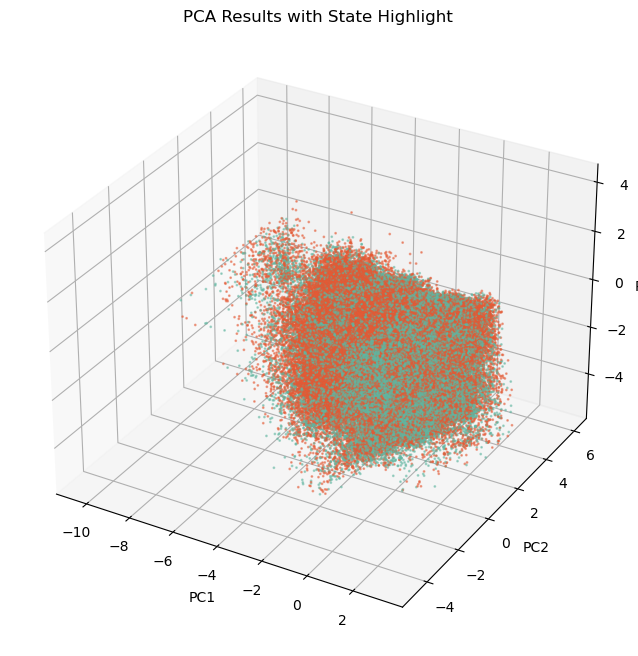

In [8]:
# Plotting all the 3 components
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pandas_df = pca_result.select("pca_features", "state").toPandas()

#Extracting PCA components
pca_components = pandas_df["pca_features"].apply(lambda x: x.toArray()).apply(pd.Series)
pandas_df = pd.concat([pandas_df, pca_components], axis=1)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = {'failed': '#e45a35', 'successful': '#61b6a1'}
pandas_df['color'] = pandas_df['state'].map(colors)

ax.scatter(pandas_df[0], pandas_df[1], pandas_df[2], c=pandas_df['color'], marker='o', alpha=0.5, s=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA Results with State Highlight')
plt.show()

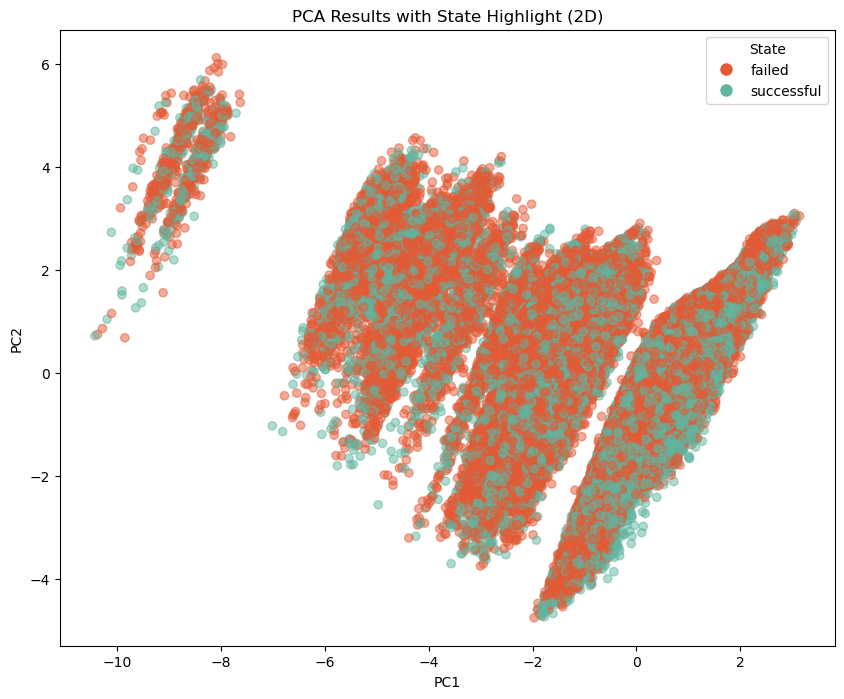

In [10]:
# Plotting the first 2 components
pandas_df = pca_result.select("pca_features", "state").toPandas()

#Extracting PCA components
pca_components = pandas_df["pca_features"].apply(lambda x: x.toArray()).apply(pd.Series)
pandas_df = pd.concat([pandas_df, pca_components], axis=1)

fig, ax = plt.subplots(figsize=(10, 8))

# Assigning colors based on the "state" column
colors = {'failed': '#e45a35', 'successful': '#61b6a1'}
pandas_df['color'] = pandas_df['state'].map(colors)

scatter = ax.scatter(pandas_df[0], pandas_df[1], c=pandas_df['color'], marker='o', alpha=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Results with State Highlight (2D)')

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in colors.items()]
ax.legend(handles=legend_labels, title="State")
plt.show()